In [ ]:
import tensorflow as tf
import os
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.102.195.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.195.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/fer2013.csv')

width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).to_numpy()

#storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [ ]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2

num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

#for xx in range(10):
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
#plt.show()

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

In [ ]:
#desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

#model.summary()

In [ ]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Epoch 1/100
  2/455 [..............................] - ETA: 2:49 - loss: 5.8420 - accuracy: 0.1562WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_train_batch_end` time: 0.2783s). Check your callbacks.


455/455 [==============================] - ETA: 0s - loss: 1.9898 - accuracy: 0.2147WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_test_batch_end` time: 0.0320s). Check your callbacks.


455/455 [==============================] - 132s 290ms/step - loss: 1.9898 - accuracy: 0.2147 - val_loss: 1.8147 - val_accuracy: 0.2594
Epoch 2/100
455/455 [==============================] - 132s 289ms/step - loss: 1.8416 - accuracy: 0.2445 - val_loss: 1.8123 - val_accuracy: 0.2607
Epoch 3/100
455/455 [==============================] - 131s 289ms/step - loss: 1.8073 - accuracy: 0.2556 - val_loss: 1.7302 - val_accuracy: 0.2969
Epoch 4/100
455/455 [==============================] - 132s 291ms/step - loss: 1.7245 - accuracy: 0.3006 - val_loss: 1.6831 - val_accuracy: 0.3074
Epoch 5/100
455/455 [==============================] - 132s 290ms/step - loss: 1.6026 - accuracy: 0.3636 - val_loss: 1.4594 - val_accuracy: 0.4127
Epoch 6/100
455/455 [==============================] - 132s 291ms/step - loss: 1.5017 - accuracy: 0.4049 - val_loss: 1.3986 - val_accuracy: 0.4409
Epoch 7/100
455/455 [==============================] - 132s 290ms/step - loss: 1.4472 - accuracy: 0.4321 - val_loss: 1.3277 - val_

In [ ]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np

json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

truey=[]
predy=[]
x = np.load('./modXtest.npy')
y = np.load('./modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

Loaded model from disk
Predicted and true label values saved
Accuracy on test set :66.53663973251602%


[[285   2  53  25  65   9  59]
 [ 10  30   4   0   4   1   3]
 [ 47   2 266  30  91  41  68]
 [ 22   0  14 769  16  18  42]
 [ 55   0  61  31 310   3 128]
 [ 10   1  45  32   8 307  11]
 [ 32   1  23  59  65  10 421]]


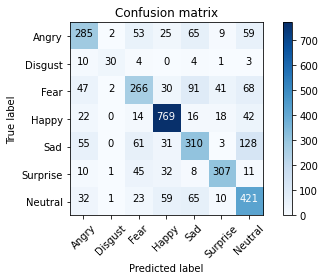

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = np.load('./truey.npy')
y_pred = np.load('./predy.npy')
cm = confusion_matrix(y_true, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

  Cloning git://github.com/PnS2019/pnslib.git to /tmp/pip-req-build-y_bl9t0b
  Running command git clone -q git://github.com/PnS2019/pnslib.git /tmp/pip-req-build-y_bl9t0b
  Created wheel for pnslib: filename=pnslib-0.1.0a1-cp36-none-any.whl size=1489619 sha256=ad500c305d28cab447aeec163f1619c362916899fdf782df3fa9ecf1b55d4559
  Stored in directory: /tmp/pip-ephem-wheel-cache-g66urki1/wheels/a2/8e/a9/c62e72840009deaa723b3a113d5c3b90acac77098d16e90eca
Successfully built pnslib
--2020-09-18 10:01:25--  https://raw.githubusercontent.com/gitshanks/fer2013/master/test.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8536 (8.3K) [image/jpeg]
Saving to: ‘test.jpg.17’

test.jpg.17         100%[===================>]   8.34K  --.-KB/s    in 0s      

2020-09-18 10:01:25 (

Emotion: Happy


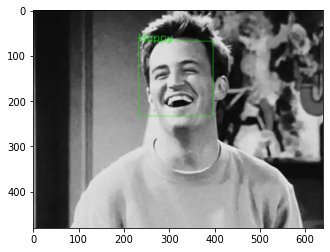

In [ ]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np
import cv2
# install pnslib
!pip install git+git://github.com/PnS2019/pnslib.git
from pnslib import utils
import matplotlib.pyplot as plt

!wget "https://raw.githubusercontent.com/gitshanks/fer2013/master/test.jpg"
!wget "https://github.com/gitshanks/fer2013/blob/master/haarcascade_frontalface_default.xml"
!wget "https://github.com/gitshanks/fer2013/tree/master/Expressions"

#loading the model
json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

#setting image resizing parameters
WIDTH = 48
HEIGHT = 48
x=None
y=None
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#loading image
full_size_image = cv2.imread("test.jpg")
print("Image Loaded")
gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
face = cv2.CascadeClassifier(utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))
faces = face.detectMultiScale(gray, 1.3  , 10)

#detecting faces
for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #predicting the emotion
        yhat= loaded_model.predict(cropped_img)
        cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
        print("Emotion: "+labels[int(np.argmax(yhat))])

plt.figure()
plt.imshow(full_size_image)
plt.show()

In [ ]:
from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

def simple_CNN(input_shape, num_classes):

    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    return model

def simpler_CNN(input_shape, num_classes):

    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(5, 5), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=16, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=64, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))

    model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))

    model.add(Flatten())
    #model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    return model

def tiny_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(8, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

def big_XCEPTION(input_shape, num_classes):
    img_input = Input(input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


if __name__ == "__main__":
    input_shape = (64, 64, 1)
    num_classes = 7
    #model = tiny_XCEPTION(input_shape, num_classes)
    #model.summary()
    model = mini_XCEPTION(input_shape, num_classes)
    model.summary()
    #model = big_XCEPTION(input_shape, num_classes)
    #model.summary()
    #model = simple_CNN((48, 48, 1), num_classes)
    #model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 62, 62, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 62, 62, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf

dataset_path = '/content/drive/MyDrive/fer2013.csv'
image_size=(48,48)

def load_fer2013():
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).to_numpy()
        return faces, emotions

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
"""
Description: Train emotion classification model
"""

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# parameters
batch_size = 32
num_epochs = 1
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'

# plots accuracy and loss curves
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# model parameters/compilation
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# callbacks

early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

# loading dataset
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)
model_info = model.fit_generator(data_generator.flow(xtrain, ytrain,
                                            batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open ("model.tflite" , "wb").write(tflite_model)
plot_model_history(model_info)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 46, 46, 8)    72          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 46, 46, 8)    32          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 46, 46, 8)    0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


UnavailableError: ignored

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''